In [1]:
import astropy.io.fits as ap
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp2d
import numpy as np

import scipy
from scipy import integrate

import math

import pandas as pd

from joblib import Parallel, delayed
import multiprocessing

In [8]:
hdu1 = ap.open("mrzqs220710t1034c2259_089.fits")
data = hdu1[0].data

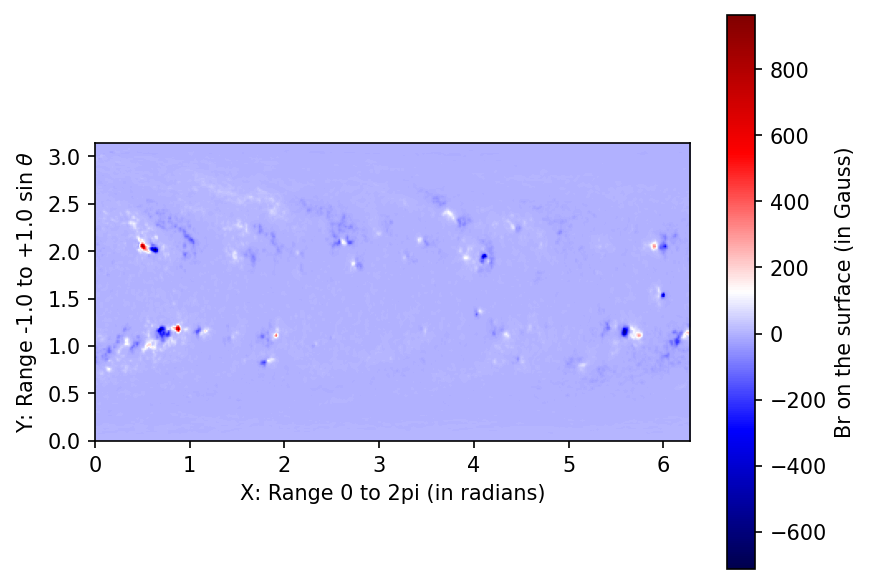

In [9]:
### MAGNETOGRAM PLOT###
plt.figure(dpi = 150)
plt.xlabel("X: Range 0 to 2pi (in radians)")
plt.ylabel(r"Y: Range -1.0 to +1.0 sin $\theta$")
im = plt.imshow(data , cmap = 'seismic' , extent = [0,2*np.pi,0,np.pi] )
cbarmagnetogram = plt.colorbar(im)
cbarmagnetogram.set_label("Br on the surface (in Gauss)")
plt.show()

In [10]:
### INTERPOLATION ###
theta = np.arccos(np.linspace(-1, 1, 180))
phi= np.linspace(0, 2*3.14, 360)
f = interp2d(phi, theta, data, kind='cubic')

In [11]:
theta = np.linspace(0, np.pi, 180)
phi = np.linspace( 0, 2*np.pi, 360)
Z = f(phi, theta)
### Apply Gaussian smoothing ###
Z = gaussian_filter(Z, sigma=(8, 8), order=0)

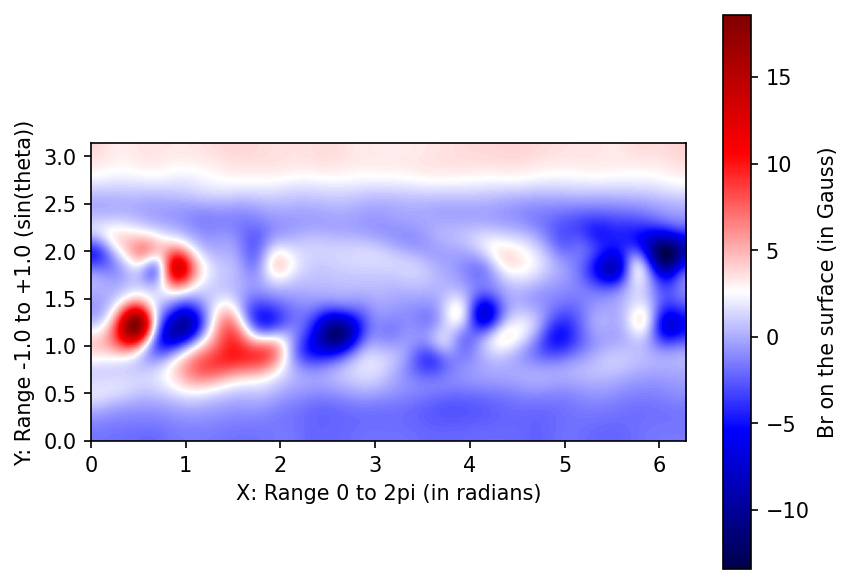

In [12]:
### MAGNETOGRAM PLOT###
plt.figure(dpi = 150)
plt.xlabel("X: Range 0 to 2pi (in radians)")
plt.ylabel("Y: Range -1.0 to +1.0 (sin(theta))")
im = plt.imshow(Z , cmap = 'seismic' , extent = [0,2*np.pi,0,np.pi] )
cbarmagnetogram = plt.colorbar(im)
cbarmagnetogram.set_label("Br on the surface (in Gauss)")
plt.show()

In [13]:
# Mapping after interpolation and smoothening 
f = interp2d(phi, theta , Z, kind='cubic')

In [14]:

l_max = 16

inputs = range(l_max)

Ro = 69.634*1E9
Rss = 2.5 * Ro

In [15]:
def compute_integration(i,l,const):
         
    func_r = lambda Theta, Phi:f(Phi,Theta)*np.sin(Theta)*scipy.special.lpmv(-i, l, np.cos(Theta))*np.cos(-i*Phi)*const

    func_i = lambda Theta,Phi:f(Phi, Theta)*np.sin(Theta)*scipy.special.lpmv(-i, l, np.cos(Theta))*np.sin(-i*Phi)*const


    ans_r = (scipy.integrate.dblquad(func_r,0,2*math.pi,lambda Theta: 0,lambda Theta: math.pi))

    ans_i = (scipy.integrate.dblquad(func_i,0,2*math.pi,lambda Theta: 0, lambda Theta: math.pi))
        
    return (l, i, ans_r[0], ans_r[1], ans_i[0], ans_i[1]) 

In [16]:
def compute_coefficients(l):
    print(l)
    const1 = (2*l + 1)/(4*np.pi)
    const2 = l*( (Ro/Rss)**(2*l + 1) )
    
    const = (const1)/(l+1+const2)
         
    answers = Parallel(n_jobs=4)(delayed(compute_integration)(i,l,const) for i in range(0,l+1))
    
    df = pd.DataFrame(answers, columns=['l', 'm' , 'ans_r', 'err_r', 'ans_i', 'err_i'])
    return df

In [17]:
DF = []

for i in inputs:
    Data = compute_coefficients(i)
    DF.append(Data)
    

0


/home/atulit-pc/anaconda3/envs/PFSS/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


1


/home/atulit-pc/anaconda3/envs/PFSS/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/atulit-pc/anaconda3/envs/PFSS/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determin

2


/home/atulit-pc/anaconda3/envs/PFSS/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


3
4
5
6
7
8
9
10
11
12
13
14
15


In [18]:
DF[-1]

,l,m,ans_r,err_r,ans_i,err_i
0,15,0,-8.083527e-04,1.488475e-08,0.000000e+00,0.000000e+00
1,15,1,-3.135698e-06,1.486805e-08,-3.416859e-04,1.488731e-08
2,15,2,1.491751e-06,1.489024e-08,9.651928e-06,1.489024e-08
3,15,3,-8.284960e-07,1.478311e-08,-1.912757e-06,1.462795e-08
4,15,4,4.161519e-08,1.420177e-08,5.166373e-08,1.456849e-08
5,15,5,1.603002e-08,1.487002e-08,1.123717e-08,1.436103e-08
6,15,6,-9.770403e-10,1.425407e-08,-2.446780e-10,1.438345e-08
7,15,7,-2.168765e-11,1.132837e-09,-3.484714e-12,1.050514e-09
8,15,8,-1.598914e-12,9.371752e-11,-3.807878e-12,8.598485e-11
9,15,9,-4.016507e-13,6.426491e-12,7.083858e-14,7.447080e-12


In [19]:
DF = pd.concat(DF).reset_index()

In [20]:
DF

,index,l,m,ans_r,err_r,ans_i,err_i
0,0,0,0,1.100646e-02,1.377964e-07,0.000000e+00,0.000000e+00
1,0,1,0,1.545458e-01,8.625514e-08,0.000000e+00,0.000000e+00
2,1,1,1,7.305889e-02,5.621282e-08,-3.147663e-01,5.032338e-08
3,0,2,0,2.137336e-01,1.302499e-07,0.000000e+00,0.000000e+00
4,1,2,1,-1.537576e-01,1.830381e-08,2.864163e-02,1.711702e-08
...,...,...,...,...,...,...,...
131,11,15,11,-1.251227e-15,5.308330e-14,-2.153073e-15,6.204384e-14
132,12,15,12,-1.765556e-16,6.016181e-15,-1.301360e-16,6.349654e-15
133,13,15,13,2.330341e-16,5.391843e-16,1.104909e-17,6.683836e-16
134,14,15,14,4.678513e-18,8.904035e-17,4.104599e-18,5.597230e-17


In [21]:
DF.to_csv("Coefficients_parallel.csv")